**Step 1: Data Collection and Storage (Web Scraping)**



In [ ]:
!pip install newspaper3k
!pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 46.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 7.3 MB/s eta 0:00:00
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13539 sha256=cf4a5dd72033306e246ffd7a94b00d3b937bd70bce1ac58af7a4dd3db8855065
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3342 sha256=6f03f39fda5b71e9e78adf6ba451be0f69cb51b052d00335ff243f297a66ab3e
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc933

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from googletrans import Translator
from google.colab import files
import time
import re
import logging

In [ ]:
# Initialize the Translator
translator = Translator()

# URL of the page to scrape
url = "https://www.aitimes.com/news/articleList.html?view_type=sm"

# Function to get news articles using NewsAPI
def get_news_articles(api_key, query, page_size=10):
    url = f"https://newsapi.org/v2/everything?q={query}&pageSize={page_size}&apiKey={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        articles = response.json()['articles']
        return articles
    else:
        print(f"Error: {response.status_code}")
        return []

# API Key for NewsAPI
api_key = 'c00b8922627b4a6686c6c183dc131e19'
api_articles = get_news_articles(api_key, 'Artificial Intelligence')

# Initialize an empty list to store the data
data = []

# Part 1: Scrape data from the website
try:
    response = requests.get(url)
    response.raise_for_status()
    soup = BeautifulSoup(response.content, "html.parser")
except requests.exceptions.RequestException as e:
    print(f"Error fetching the main page: {e}")
    soup = None

if soup:
    news_section = soup.find("section", id="section-list")
    news_items = news_section.find_all("li") if news_section else []

    for item in news_items:
        try:
            title_tag = item.find("a", class_="thumb")
            link = title_tag["href"] if title_tag else None
            full_link = f"https://www.aitimes.com{link}" if link else "Link not available"

            title = item.find("h4", class_="titles").get_text(strip=True) if item.find("h4", class_="titles") else "Title not available"
            translated_title = translator.translate(title, src='ko', dest='en').text

            date = "Date not available"
            byline_span = item.find("span", class_="byline")
            if byline_span:
                em_tags = byline_span.find_all("em")
                if len(em_tags) > 1:
                    date = em_tags[1].get_text(strip=True)

            translated_content = "Content not available"
            if link:
                try:
                    news_response = requests.get(full_link)
                    news_response.raise_for_status()
                    news_soup = BeautifulSoup(news_response.content, "html.parser")

                    content_div = (news_soup.find("article", id="article-veiw-content-div") or
                                   news_soup.find("div", class_="article-body") or
                                   news_soup.find("div", class_="content-body"))
                    full_content = content_div.get_text(strip=True) if content_div else "Content not available"
                    translated_content = translator.translate(full_content, src='ko', dest='en').text
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching content from {full_link}: {e}")
                except Exception as e:
                    print(f"Error translating content: {e}")

            data.append({
                'Title': translated_title,
                'Date': date,
                'URL': full_link,
                'Content': translated_content
            })
            time.sleep(1)

        except Exception as e:
            print(f"Error processing news item: {e}")

# Part 2: Add NewsAPI articles to the data
for article in api_articles:
    data.append({
        'Title': article['title'],
        'Date': article['publishedAt'],
        'URL': article['url'],
        'Content': article['description']
    })

# Create DataFrame and save to CSV
df = pd.DataFrame(data, columns=['Title', 'Content', 'Date', 'URL'])
if not df.empty:
    df.to_csv('ai_and_API.csv', index=False)
    print("Data saved too ai_and_API.csv")
else:
    print("No data to write!")


Data saved too ai_and_API.csv


In [ ]:
# Initialize translator
translator = Translator()

# Define the URL to scrape
url = "https://spri.kr/search/ksearch?s_field=title%3A%3Acontent%3A%3Aauthors&s_keyword=ai"

# Send a request to the website and parse the HTML content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful
soup = BeautifulSoup(response.content, "html.parser")

# Extract article data
articles = []
for item in soup.select("div.com_list_box li"):
    title_tag = item.select_one(".title a")
    title = title_tag.get_text(strip=True) if title_tag else None
    link = f"https://spri.kr{title_tag['href']}" if title_tag else None

    # Extract date using only the first valid 'YYYY-MM-DD' format found
    date = None
    date_element = item.select_one(".data_list_area .text")  # Ensure only one date element is selected
    if date_element:
        date_text = date_element.get_text(strip=True)
        # Verify that this is a valid date and ignore anything that doesn’t match the date format
        date_match = re.match(r'\d{4}-\d{2}-\d{2}', date_text)
        if date_match:
            date = date_match.group(0)

    # Extract description
    description = item.select_one("a.text p").get_text(strip=True) if item.select_one("a.text p") else None

    # Translate title and description into English
    try:
        title_en = translator.translate(title, src='ko', dest='en').text if title else None
        description_en = translator.translate(description, src='ko', dest='en').text if description else None
    except Exception as e:
        print(f"Translation error: {e}")
        title_en, description_en = title, description

    # Append the translated data to the articles list if a valid date and content are present
    if date and description_en:  # Ensure both date and content are present
        articles.append({
            "Title": title_en,
            "Content": description_en,
            "Date": date,
            "URL": link
        })

    # Small delay to avoid rate limiting
    time.sleep(1)

# Create DataFrame, which should now contain only valid rows with single dates
df = pd.DataFrame(articles, columns=["Title","Content", "Date", "URL"])

# Save DataFrame as CSV
df.to_csv("SPRI.csv", index=False)


In [ ]:
# Initialize translator
translator = Translator()

# Define the URL to scrape
url = 'https://m.etnews.com/search/news.html?kwd=ai'

# Send a request to the website
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
try:
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Check if the request was successful
    soup = BeautifulSoup(response.content, 'html.parser')
except requests.exceptions.RequestException as e:
    print(f"Error fetching the main page: {e}")
    soup = None

# Extract articles and their details
articles = []

if soup:
    for item in soup.select('ul#contents_list > li'):
        try:
            # Extract the title, link, and date
            title_el = item.select_one('div.text > strong > a')
            if title_el:
                title = title_el.text.strip()
                link = "https://m.etnews.com" + title_el['href']
                date = item.select_one('div.flex > span.date').text.strip()

                # Fetch the full content from the article link
                try:
                    article_response = requests.get(link, headers=headers)
                    article_response.raise_for_status()
                    article_soup = BeautifulSoup(article_response.content, 'html.parser')

                    # Collect paragraphs from the article body
                    paragraphs = article_soup.select_one('div#articleBody').find_all('p') if article_soup.select_one('div#articleBody') else []
                    content = "\n".join([p.text.strip() for p in paragraphs])

                    # Ensure title and content are not None before translating
                    if title:
                        title_en = translator.translate(title, src='ko', dest='en').text
                    else:
                        title_en = "Title not available"

                    if content:
                        time.sleep(1)  # Delay to avoid rate limiting
                        content_en = translator.translate(content, src='ko', dest='en').text
                    else:
                        content_en = "Content not available"
                except requests.exceptions.RequestException as e:
                    print(f"Error fetching article content from {link}: {e}")
                    content, content_en = "Content not available", "Content not available"
                except Exception as e:
                    print(f"Error in translation: {e}")
                    title_en, content_en = title, content  # Fallback to original if translation fails

                # Append translated data to articles list
                articles.append({
                    'Title': title_en,
                    'Content': content_en,
                    'Date': date,
                    'URL': link
                })

        except Exception as e:
            print(f"Error processing article item: {e}")

# Create DataFrame with specified column order
df = pd.DataFrame(articles, columns=['Title', 'Content', 'Date', 'URL'])

# Save DataFrame as a CSV file
df.to_csv('eetimes.csv', index=False)
print("Data saved to eetimes.csv")


Data saved to eetimes.csv


In [ ]:
# Base URL for relative links
base_url = "https://eng.nia.or.kr"

# URL for the News and Events section
url = "https://eng.nia.or.kr/site/nia_eng/ex/bbs/List.do?cbIdx=80938"

# Fetch the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Parse news articles
articles = []
news_list = soup.find('div', class_='board_type01').find_all('li')

for item in news_list:
    title_tag = item.find('span', class_='subject searchItem')
    if title_tag:
        title = title_tag.get_text(strip=True)

        # Extract publication date
        date_info = item.find('span', class_='src').find_all('em')
        if date_info and len(date_info) >= 1:
            date = date_info[0].get_text(strip=True)
        else:
            date = None

        # Get the link to the full article (adjusting the URL)
        partial_link = item.find('a')['onclick']
        # Extract the link ID from the onclick function using string manipulation
        cbIdx = '80938'  # From the main page URL, this seems to be constant
        bcIdx = partial_link.split(",")[1].strip("'")
        article_url = f"{base_url}/site/nia_eng/ex/bbs/View.do?cbIdx={cbIdx}&bcIdx={bcIdx}"

        # Fetch and parse the full article content
        article_response = requests.get(article_url)
        article_soup = BeautifulSoup(article_response.text, 'html.parser')

        # Find the content within `div` with class `con_area`
        content_div = article_soup.find('div', class_='con_area')
        if content_div:
            content = content_div.get_text(strip=True)
        else:
            content = "Content not found"

        # Append to articles list
        articles.append({
            'Title': title,
            'Content': content,
            'Date': date,
            'URL': article_url
        })

        # Pause between requests to avoid overloading the server
        time.sleep(1)  # Adjust based on the site's rate limits

# Create a DataFrame to store the articles
df = pd.DataFrame(articles)

# Optionally, save to CSV
df.to_csv("nia_news_articles_full.csv", index=False)


In [ ]:
# Base URL for relative links
base_url = "https://eng.nia.or.kr"

# URL for the Research Paper section under Publication
url = "https://eng.nia.or.kr/site/nia_eng/ex/bbs/List.do?cbIdx=62611"

# Fetch the webpage
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Parse research papers
research_papers = []
papers_list = soup.find('div', class_='board_type01').find_all('li')  # Adjusted to target the list of research papers

for item in papers_list:
    title_tag = item.find('span', class_='subject searchItem')
    if title_tag:
        title = title_tag.get_text(strip=True)

        # Extract publication date
        date_info = item.find('span', class_='src').find_all('em')
        if date_info and len(date_info) >= 1:
            date = date_info[0].get_text(strip=True)
        else:
            date = None

        # Get the link to the full research paper (adjusting the URL)
        partial_link = item.find('a')['onclick']
        # Extract the link ID from the onclick function using string manipulation
        cbIdx = '62611'  # From the main page URL, this seems to be constant for Research Paper section
        bcIdx = partial_link.split(",")[1].strip("'")
        paper_url = f"{base_url}/site/nia_eng/ex/bbs/View.do?cbIdx={cbIdx}&bcIdx={bcIdx}"

        # Fetch and parse the full research paper content
        paper_response = requests.get(paper_url)
        paper_soup = BeautifulSoup(paper_response.text, 'html.parser')

        # Find the content within `div` with class `con_area`
        content_div = paper_soup.find('div', class_='con_area')
        if content_div:
            content = content_div.get_text(strip=True)
        else:
            content = "Content not found"

        # Append to research_papers list
        research_papers.append({
            'Title': title,
            'Content': content,
            'Date': date,
            'URL': paper_url

        })

        time.sleep(1)

# Create a DataFrame to store the research papers
df = pd.DataFrame(research_papers)

# Optionally, save to CSV
df.to_csv("nia_research_papers.csv", index=False)


In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Base URL of TTA's news page
BASE_URL = "https://www.tta.or.kr/eng/selectBbsNttList.do"

# Headers to simulate a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
}

def fetch_article_content(article_link):
    """Fetch the article content from the provided link."""
    try:
        logging.info(f"Fetching content from: {article_link}")
        response = requests.get(article_link, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')

        # Attempt to locate the main content area using multiple approaches
        content_div = soup.find('div', class_='view-content') or soup.find('div', class_='contents') or soup.find('div', id='contents')

        if content_div:
            # Extract all text and filter out irrelevant parts
            content_text = content_div.get_text(strip=True)
            return content_text if content_text else "No content found"

        # Fallback: Attempt to extract from broader elements if specific divs aren't found
        paragraphs = soup.find_all('p')
        fallback_content = ' '.join([p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True)])

        return fallback_content.strip() if fallback_content else "No content found"

    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to retrieve the article content: {e}")
        return "Could not fetch content"

def fetch_articles(session):
    """Fetch articles from the TTA website for page 1 only."""
    articles = []
    page_number = 1

    # Prepare parameters for the request for page 1
    params = {
        'bbsNo': '109',
        'key': '159',
        'pageIndex': page_number
    }

    logging.info(f"Fetching page {page_number}...")

    try:
        response = session.get(BASE_URL, params=params, headers=headers)
        response.raise_for_status()

        soup = BeautifulSoup(response.text, 'html.parser')
        table = soup.find('table')

        if not table:
            logging.warning("No table found on the page.")
            return articles

        rows = table.find_all('tr')[1:]  # Skip header row
        if not rows:
            logging.warning("No article rows found.")
            return articles

        for row in rows:
            cells = row.find_all('td')
            if len(cells) > 0:
                title_tag = cells[1].find('a')
                title = title_tag.get_text(strip=True) if title_tag else "No Title"

                # Construct the link correctly
                if title_tag and 'href' in title_tag.attrs:
                    raw_link = title_tag['href']
                    link = "https://www.tta.or.kr" + raw_link if raw_link.startswith('/') else "https://www.tta.or.kr/" + raw_link
                    link = link.replace("/selectBbsNttView.do", "/eng/selectBbsNttView.do")  # Use English path
                else:
                    link = "No Link"

                date = cells[3].get_text(strip=True) if len(cells) > 3 else "No Date"

                # Fetch the article content
                article_content = fetch_article_content(link)

                articles.append({
                    'Title': title,
                    'Content': article_content,
                    'Date': date,
                    'URL': link,

                })

    except requests.exceptions.RequestException as e:
        logging.error(f"Failed to retrieve the webpage: {e}")

    return articles

def save_to_csv(articles):
    """Save the list of articles to a CSV file."""
    if articles:
        news_data = pd.DataFrame(articles)
        news_data.to_csv('tta_news_data.csv', index=False)
        logging.info("Data has been successfully saved to tta_news_data.csv")
    else:
        logging.warning("No articles to save.")

# Create a session for requests and fetch articles
with requests.Session() as session:
    articles = fetch_articles(session)
    save_to_csv(articles)


In [ ]:
# Base URL for relative links
base_url = "https://arstechnica.com"

# URL of Ars Technica AI section
url = "https://arstechnica.com/ai/"
headers = {'User-Agent': 'Mozilla/5.0'}

# Initialize list to store articles
articles = []

# Request the page content
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find articles
    article_list = soup.find_all('article')

    # Loop through the articles and extract details
    for article in article_list:
        try:
            title_tag = article.find('h2')
            link_tag = article.find('a', href=True)
            date_tag = article.find('time', datetime=True)  # Find date

            if title_tag and link_tag and date_tag:
                title = title_tag.get_text(strip=True)
                link = link_tag['href']
                date = date_tag['datetime']  # Extract the datetime attribute

                # If link is relative, prepend the base URL
                if link.startswith('/'):
                    link = f"{base_url}{link}"

                # Initialize content
                content = "N/A"

                # Try to get content by following the link
                try:
                    article_response = requests.get(link, headers=headers)
                    if article_response.status_code == 200:
                        article_soup = BeautifulSoup(article_response.content, 'html.parser')

                        # Extract content
                        content_div = article_soup.find('div')
                        if content_div:
                            paragraphs = content_div.find_all('p')
                            content = ' '.join([para.get_text(strip=True) for para in paragraphs])

                except Exception as e:
                    print(f"Could not extract additional details from: {link}\nError: {e}")

                # Append to articles list
                articles.append({
                    'Title': title,
                    'Content': content,
                    'Date': date,
                    'URL': link
                })

                # Add a short delay to prevent overwhelming the server
                time.sleep(1)
        except Exception as e:
            print(f"Error processing an article: {e}")
else:
    print("Failed to retrieve the page.")

# Create a DataFrame to store the articles with specified columns
df = pd.DataFrame(articles, columns=['Title', 'Content', 'Date', 'URL'])

# Save to CSV
csv_file = "arstechnica_news_updated.csv"
df.to_csv(csv_file, index=False)

print(f"Data has been saved to {csv_file}")


Data has been saved to arstechnica_news_updated.csv


In [ ]:
# Base URL of VentureBeat
base_url = "https://venturebeat.com/"

# URL of the VentureBeat website to scrape
url = "https://venturebeat.com/category/ai/"
headers = {'User-Agent': 'Mozilla/5.0'}

# Initialize list to store articles
articles = []

# Request the page content
response = requests.get(url, headers=headers)

# Check if the request was successful
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find articles based on the provided structure
    articles_list = soup.find_all('article', class_='ArticleListing')

    # Loop through the articles and extract details
    for article in articles_list[:10]:  # Limiting to the first 10 articles
        try:
            # Extract title
            title_tag = article.find('h2', class_='ArticleListing__title')
            link_tag = article.find('a', class_='ArticleListing__image-link')
            date_tag = article.find('time', class_='ArticleListing__time')

            if title_tag and link_tag and date_tag:
                title = title_tag.get_text(strip=True)
                link = link_tag['href']
                date = date_tag['datetime']  # Extracting the datetime attribute

                # If link is relative, prepend the base URL
                if link.startswith('/'):
                    link = f"{base_url}{link}"

                # Initialize content
                content = "N/A"

                # Try to get content by following the link
                try:
                    article_response = requests.get(link, headers=headers)
                    if article_response.status_code == 200:
                        article_soup = BeautifulSoup(article_response.content, 'html.parser')

                        # Extract content (typically in 'div' with class 'article-content')
                        content_div = article_soup.find('div', class_='article-content')
                        if content_div:
                            paragraphs = content_div.find_all('p')
                            content = ' '.join([para.get_text(strip=True) for para in paragraphs])

                except Exception as e:
                    print(f"Could not extract additional details from: {link}\nError: {e}")

                # Append to articles list
                articles.append({
                    'Title': title,
                    'Content': content,
                    'Date': date,
                    'URL': link
                })

                # Add a short delay to prevent overwhelming the server
                time.sleep(1)
        except Exception as e:
            print(f"Error processing an article: {e}")
else:
    print("Failed to retrieve the main page.")

# Create a DataFrame to store the articles with specified columns
df = pd.DataFrame(articles, columns=['Title', 'Content', 'Date', 'URL'])

# Save to CSV
csv_file = "venturebeat_news_updated.csv"
df.to_csv(csv_file, index=False)

print(f"Data has been saved to {csv_file}")


Data has been saved to venturebeat_news_updated.csv


In [ ]:
df.head()

,Title,Content,Date,URL
0,Samsung SDS is appointed as the new representa...,"Lee Jun -hee, the new president of Samsung SDS...",2024.11.28 15:24,https://www.aitimes.com/news/articleView.html?...
1,"Deep Nide launched next year…""Actual customs c...",'AI Video Integrated Management Solution' Demo...,2024.11.28 15:22,https://www.aitimes.com/news/articleView.html?...
2,Deepbrain AI introduces AI announcers to Japan...,(Photo: Deepbrain AI) Created artificial intel...,2024.11.28 15:19,https://www.aitimes.com/news/articleView.html?...
3,Kolon Benit shares AI conversion case in 'DX F...,Kolon Benite staff is demonstrating KOAIBOT's ...,2024.11.28 15:17,https://www.aitimes.com/news/articleView.html?...
4,"Shin Shin -ae, head of NIA, “Focus on building...","Shin Shin -ae, head of the Korea Intelligence ...",2024.11.28 15:13,https://www.aitimes.com/news/articleView.html?...


In [ ]:
# New
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For removing stopwords
nltk.download('wordnet')  # For lemmatization
nltk.download('punkt_tab')

# Initialize the lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    if not isinstance(text, str):
        return ''  # Handle non-string inputs
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()  # Remove special characters and convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(cleaned_tokens)

# Apply preprocessing to the 'Content' column
df['cleaned_text'] = df['Content'].apply(preprocess)
print("Data preprocessing completed.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Data preprocessing completed.


**Step 2: Data Preprocessing (NLP Techniques)**



In [ ]:
# import nltk
# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# import pandas as pd #


# # Download necessary NLTK data files, including 'punkt_tab'
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))

# def preprocess(text):
#     # Check if text is a string before proceeding
#     if isinstance(text, str):
#         # Tokenize text
#         tokens = word_tokenize(text)
#         # Remove stop words and lemmatize
#         cleaned_tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens if word.isalnum() and word not in stop_words]
#         return ' '.join(cleaned_tokens)
#     else:
#         # Handle non-string values, e.g., return an empty string or a placeholder
#         return ''  # Or 'NaN' or any other suitable value

# # Apply preprocessing to articles, handling potential NaN values
# df['cleaned_text'] = df['Content'].apply(lambda x: preprocess(x) if pd.notna(x) else '') # Handle NaN values

In [ ]:
df.head()

,Title,Content,Date,URL,cleaned_text
0,Samsung SDS is appointed as the new representa...,"Lee Jun -hee, the new president of Samsung SDS...",2024.11.28 15:24,https://www.aitimes.com/news/articleView.html?...,lee jun hee new president samsung sd photo sam...
1,"Deep Nide launched next year…""Actual customs c...",'AI Video Integrated Management Solution' Demo...,2024.11.28 15:22,https://www.aitimes.com/news/articleView.html?...,ai video integrated management solution demons...
2,Deepbrain AI introduces AI announcers to Japan...,(Photo: Deepbrain AI) Created artificial intel...,2024.11.28 15:19,https://www.aitimes.com/news/articleView.html?...,photo deepbrain ai created artificial intellig...
3,Kolon Benit shares AI conversion case in 'DX F...,Kolon Benite staff is demonstrating KOAIBOT's ...,2024.11.28 15:17,https://www.aitimes.com/news/articleView.html?...,kolon benite staff demonstrating koaibots ai c...
4,"Shin Shin -ae, head of NIA, “Focus on building...","Shin Shin -ae, head of the Korea Intelligence ...",2024.11.28 15:13,https://www.aitimes.com/news/articleView.html?...,shin shin ae head korea intelligence informati...


**Step 3: Named Entity Recognition (NER)**

In [ ]:
import spacy

# Load spaCy's pre-trained NER model
nlp = spacy.load("en_core_web_sm")

def extract_standard_entities(text):
    """
    Extract entities using spaCy's standard NER model.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply standard NER to the preprocessed text
df['standard_entities'] = df['cleaned_text'].apply(extract_standard_entities)
print("Standard NER applied successfully.")


Standard NER applied successfully.


In [ ]:
import re

def extract_enhanced_entities(text):
    """
    Enhance NER with domain-specific logic for AI-related terms.
    """
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Add custom logic for AI-specific terms
    if re.search(r'\bAI\b.*\b(trend|framework|tool)\b', text, re.IGNORECASE):
        entities.append(('AI Trend', 'TECH_TREND'))
    return entities

# Apply enhanced NER to the preprocessed text
df['enhanced_entities'] = df['cleaned_text'].apply(extract_enhanced_entities)
print("Enhanced domain-specific NER applied successfully.")


Enhanced domain-specific NER applied successfully.


In [ ]:
df.head()

,Title,Content,Date,URL,cleaned_text,standard_entities,enhanced_entities
0,Samsung SDS is appointed as the new representa...,"Lee Jun -hee, the new president of Samsung SDS...",2024.11.28 15:24,https://www.aitimes.com/news/articleView.html?...,lee jun hee new president samsung sd photo sam...,"[(lee jun hee new, PERSON), (samsung, PERSON),...","[(lee jun hee new, PERSON), (samsung, PERSON),..."
1,"Deep Nide launched next year…""Actual customs c...",'AI Video Integrated Management Solution' Demo...,2024.11.28 15:22,https://www.aitimes.com/news/articleView.html?...,ai video integrated management solution demons...,"[(yearit, GPE), (part ministry science ict min...","[(yearit, GPE), (part ministry science ict min..."
2,Deepbrain AI introduces AI announcers to Japan...,(Photo: Deepbrain AI) Created artificial intel...,2024.11.28 15:19,https://www.aitimes.com/news/articleView.html?...,photo deepbrain ai created artificial intellig...,"[(asahi, ORG), (japan electric co ltd necnec, ...","[(asahi, ORG), (japan electric co ltd necnec, ..."
3,Kolon Benit shares AI conversion case in 'DX F...,Kolon Benite staff is demonstrating KOAIBOT's ...,2024.11.28 15:17,https://www.aitimes.com/news/articleView.html?...,kolon benite staff demonstrating koaibots ai c...,"[(kolon benit, PERSON), (kolon benit, PERSON),...","[(kolon benit, PERSON), (kolon benit, PERSON),..."
4,"Shin Shin -ae, head of NIA, “Focus on building...","Shin Shin -ae, head of the Korea Intelligence ...",2024.11.28 15:13,https://www.aitimes.com/news/articleView.html?...,shin shin ae head korea intelligence informati...,"[(shin shin, PERSON), (head korea intelligence...","[(shin shin, PERSON), (head korea intelligence..."



**Step 4: Text Classification (Supervised Learning)**


In [ ]:
# Example: Assign labels (Modify based on actual categories)
categories = ['Technology Trends', 'Product Development', 'Research']
df['label'] = categories * (len(df) // len(categories)) + categories[:len(df) % len(categories)]
df['encoded_label'] = df['label'].astype('category').cat.codes  # Convert to numerical labels


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['encoded_label'],
    test_size=0.2,
    random_state=42
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Adjust based on your dataset
    stop_words='english',
    ngram_range=(1, 2)  # Unigrams and bigrams
)

# Transform text data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train the XGBoost model
xgb = XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)
xgb.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))


Accuracy: 0.39285714285714285
Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.22      0.33      0.27         6
           2       0.50      0.38      0.43        13

    accuracy                           0.39        28
   macro avg       0.39      0.39      0.38        28
weighted avg       0.42      0.39      0.40        28



In [ ]:
df.head()

,Title,Content,Date,URL,cleaned_text,standard_entities,enhanced_entities,label,encoded_label
0,Samsung SDS is appointed as the new representa...,"Lee Jun -hee, the new president of Samsung SDS...",2024.11.28 15:24,https://www.aitimes.com/news/articleView.html?...,lee jun hee new president samsung sd photo sam...,"[(lee jun hee new, PERSON), (samsung, PERSON),...","[(lee jun hee new, PERSON), (samsung, PERSON),...",Technology Trends,2
1,"Deep Nide launched next year…""Actual customs c...",'AI Video Integrated Management Solution' Demo...,2024.11.28 15:22,https://www.aitimes.com/news/articleView.html?...,ai video integrated management solution demons...,"[(yearit, GPE), (part ministry science ict min...","[(yearit, GPE), (part ministry science ict min...",Product Development,0
2,Deepbrain AI introduces AI announcers to Japan...,(Photo: Deepbrain AI) Created artificial intel...,2024.11.28 15:19,https://www.aitimes.com/news/articleView.html?...,photo deepbrain ai created artificial intellig...,"[(asahi, ORG), (japan electric co ltd necnec, ...","[(asahi, ORG), (japan electric co ltd necnec, ...",Research,1
3,Kolon Benit shares AI conversion case in 'DX F...,Kolon Benite staff is demonstrating KOAIBOT's ...,2024.11.28 15:17,https://www.aitimes.com/news/articleView.html?...,kolon benite staff demonstrating koaibots ai c...,"[(kolon benit, PERSON), (kolon benit, PERSON),...","[(kolon benit, PERSON), (kolon benit, PERSON),...",Technology Trends,2
4,"Shin Shin -ae, head of NIA, “Focus on building...","Shin Shin -ae, head of the Korea Intelligence ...",2024.11.28 15:13,https://www.aitimes.com/news/articleView.html?...,shin shin ae head korea intelligence informati...,"[(shin shin, PERSON), (head korea intelligence...","[(shin shin, PERSON), (head korea intelligence...",Product Development,0


**Step 5: Text Summarization**

In [ ]:
# # Step 1: Import Required Libraries
# import pandas as pd
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# # Step 2: Load Pre-Trained Summarization Model
# model_name = "facebook/bart-large-cnn"  # You can replace with "t5-small", "t5-base", etc.
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# # Step 3: Define Summarization Function
# def summarize_text(text, max_length=130, min_length=30, length_penalty=2.0):
#     """
#     Summarize the input text using a pre-trained transformer model.

#     Args:
#     - text (str): The input text to summarize.
#     - max_length (int): Maximum length of the summary.
#     - min_length (int): Minimum length of the summary.
#     - length_penalty (float): Penalty to discourage excessively short or long summaries.

#     Returns:
#     - str: The generated summary.
#     """
#     inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", truncation=True, max_length=512)
#     summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=length_penalty, num_beams=4, early_stopping=True)
#     return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# # Step 4: Apply Summarization to Dataset
# # Example using the 'cleaned_text' column
# df['summary'] = df['cleaned_text'].apply(lambda x: summarize_text(x) if isinstance(x, str) else '')

# # Step 5: Save the Results
# df[['Title', 'Content', 'cleaned_text', 'summary']].to_csv("summarized_articles.csv", index=False)
# print("Summarization complete. Results saved to 'summarized_articles.csv'.")


In [ ]:
from transformers import pipeline

# Load summarization model
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize_text(text):
    return summarizer(text, max_length=130, min_length=30, do_sample=False)[0]['summary_text']

# Apply summarization to the cleaned text
df['summary'] = df['Content'].apply(lambda x: summarize_text(x[:1000]))

def summarize_text(text):
    input_length = len(text.split())
    max_len = min(130, input_length // 2)  # Adjust max length based on input length
    return summarizer(text, max_length=max_len, min_length=max(10, input_length // 4), do_sample=False)[0]['summary_text']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 130, but your input_length is only 111. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=55)
Your max_length is set to 130, but your input_length is only 47. Since this is a summa

In [ ]:
pd.set_option('display.max_colwidth', None)

# Display the column
print(df["summary"].head())

0                                Samsung SDS announced on the 28th that Samsung Electronics Lee Jun -hee has appointed the vice president of Samsung Electronics as the new CEO. He is an IT and telecommunications technology expert who has earned a master's and doctorate degree in MIT.
1                                                                          AI convergence customs clearance video management solution' project aims to complete the development next year. The number of overseas fastballs from e -commerce imported into Korea is increasing year by year.
2    Announcer will be in charge of weather forecasts on the terrestrial and Internet broadcasts of the Ryukyu Hiahi from January 2025. It is said that it is to resolve the lack of professional talents related to program production, which is one of the chronic issues of Broadcasting.
3                                                                                      Kolon Benit will showcase artificial intelligence (AI) bus

**Step 6: Keyword Extraction**

In [ ]:
# !pip install keybert
# !pip install --upgrade httpx


In [ ]:
# # New
# # Step 1: Import Required Libraries
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from keybert import KeyBERT
# import spacy

# # Step 2: Load Dataset
# # Assuming `df` already contains the cleaned text in the 'cleaned_text' or 'summary' column.

# # Step 3: TF-IDF Keyword Extraction
# def extract_tfidf_keywords(text, vectorizer, top_n=5):
#     """
#     Extract top N keywords using TF-IDF.
#     """
#     tfidf_matrix = vectorizer.transform([text])
#     scores = zip(vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0])
#     sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
#     return [word for word, score in sorted_scores[:top_n]]

# # Initialize TF-IDF Vectorizer
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
# tfidf_vectorizer.fit(df['summary'])  # Use 'summary' or 'cleaned_text' column

# # Apply TF-IDF Keyword Extraction
# df['tfidf_keywords'] = df['summary'].apply(
#     lambda x: extract_tfidf_keywords(x, tfidf_vectorizer) if isinstance(x, str) else []
# )

# # Step 4: KeyBERT Keyword Extraction
# kw_model = KeyBERT()

# def extract_keybert_keywords(text, model, top_n=5):
#     """
#     Extract top N keywords using KeyBERT.
#     """
#     keywords = model.extract_keywords(text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=top_n)
#     return [keyword for keyword, score in keywords]

# # Apply KeyBERT Keyword Extraction
# df['keybert_keywords'] = df['summary'].apply(
#     lambda x: extract_keybert_keywords(x, kw_model) if isinstance(x, str) else []
# )

# # Step 5: Named Entity Recognition (NER)
# nlp = spacy.load("en_core_web_sm")

# def extract_ner_keywords(text):
#     """
#     Extract keywords using Named Entity Recognition (NER).
#     """
#     doc = nlp(text)
#     return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'PERSON', 'GPE', 'PRODUCT']]

# # Apply NER Keyword Extraction
# df['ner_keywords'] = df['summary'].apply(
#     lambda x: extract_ner_keywords(x) if isinstance(x, str) else []
# )

# # Step 6: Save Results
# df[['Title', 'summary', 'tfidf_keywords', 'keybert_keywords', 'ner_keywords']].to_csv("extracted_keywords.csv", index=False)
# print("Keyword extraction complete. Results saved to 'extracted_keywords.csv'.")


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract keywords using TF-IDF
vectorizer = TfidfVectorizer(max_df=0.85, stop_words='english', max_features=10)
tfidf_matrix = vectorizer.fit_transform(df['cleaned_text'])
feature_names = vectorizer.get_feature_names_out()

# Function to get top keywords for each document
def extract_keywords(row_index):
    row = tfidf_matrix[row_index].toarray().flatten()  # Convert row to array
    top_indices = row.argsort()[-10:][::-1]  # Get indices of top 10 keywords
    return [feature_names[i] for i in top_indices]

# Apply the function to each document in 'cleaned_text'
df['keywords'] = [extract_keywords(i) for i in range(tfidf_matrix.shape[0])]
df.to_csv("extracted_keywords.csv", index=False)

In [ ]:
from google.colab import files
files.download("extracted_keywords.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df['keywords']

,keywords
0,"[ai, time, technology, new, company, year, model, service, data, development]"
1,"[ai, development, time, year, technology, data, service, model, new, company]"
2,"[ai, time, technology, company, year, service, model, new, data, development]"
3,"[ai, time, service, year, data, technology, company, new, model, development]"
4,"[data, ai, company, year, time, technology, model, new, service, development]"
...,...
134,"[ai, service, model, time, company, year, new, technology, data, development]"
135,"[data, company, ai, model, time, year, new, service, technology, development]"
136,"[model, data, ai, company, new, service, time, year, technology, development]"
137,"[model, new, time, service, ai, year, technology, development, data, company]"


**Step 7: Report Generation and Visualization**

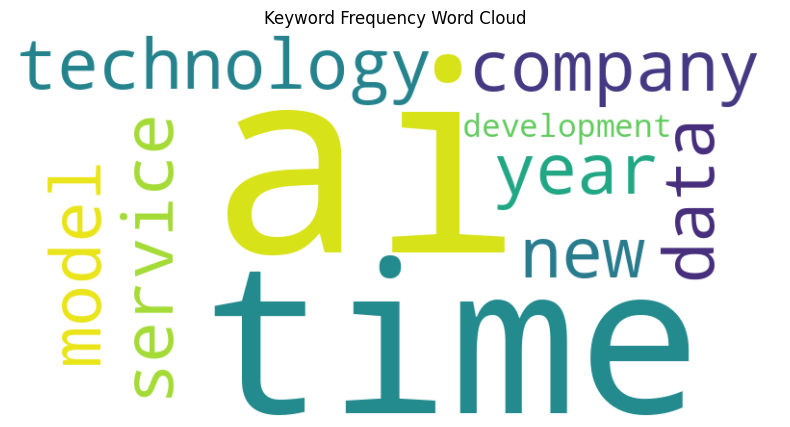

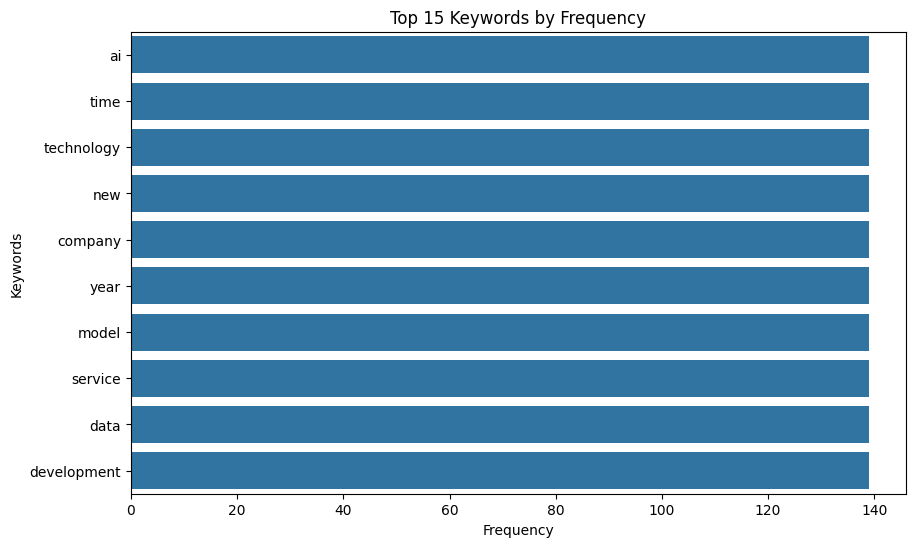

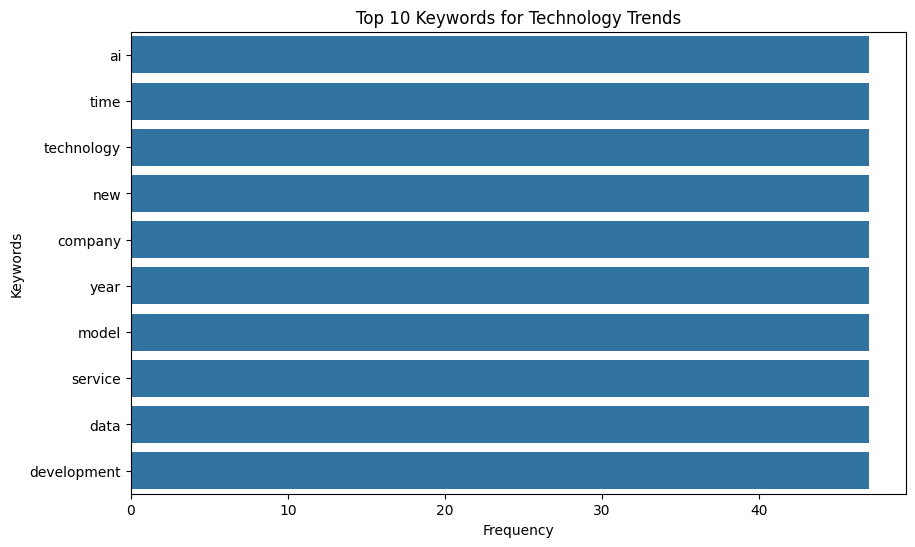

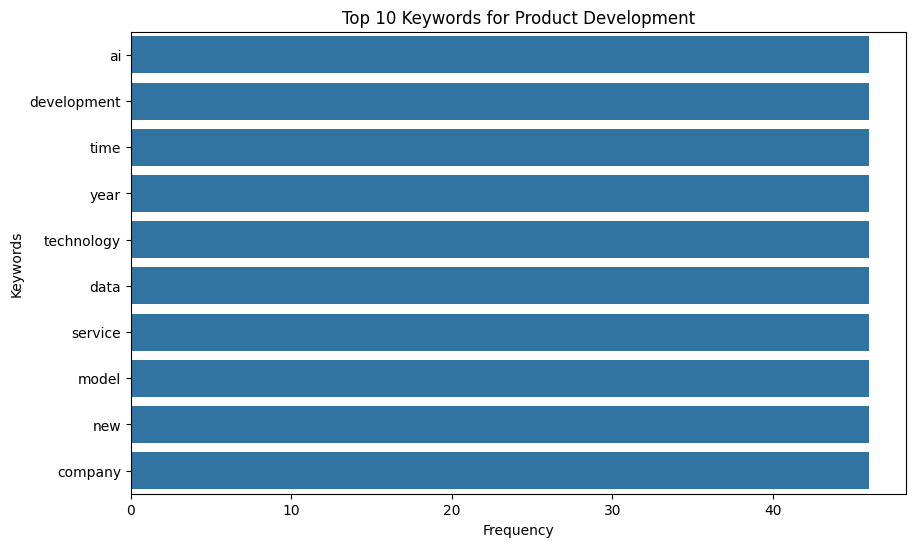

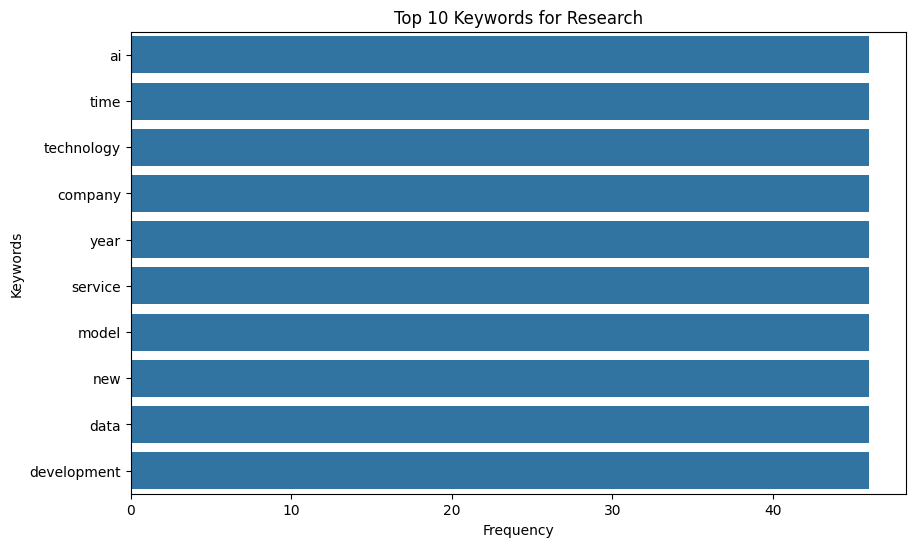

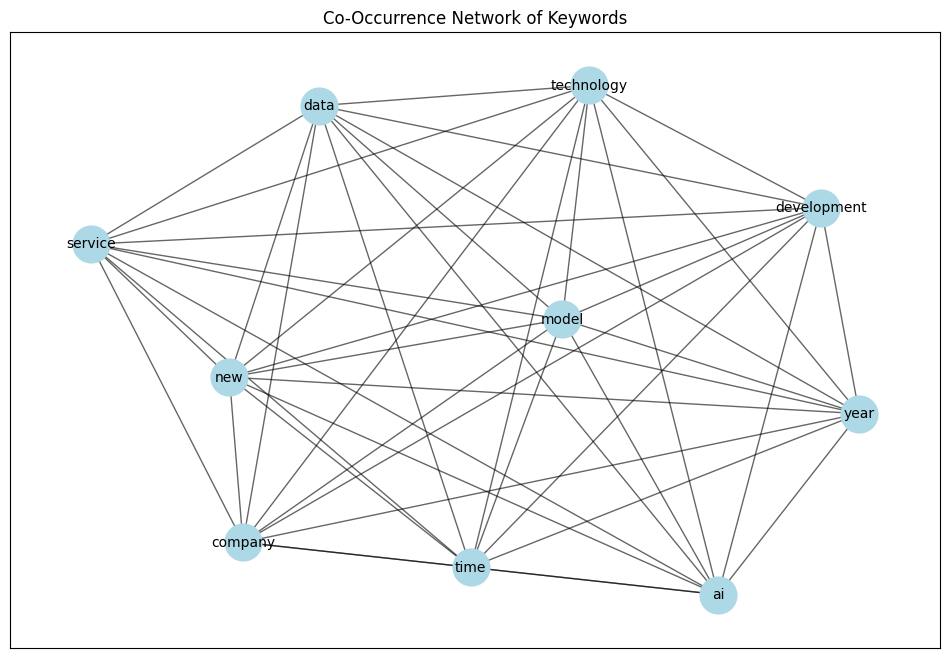

In [ ]:
# Import necessary libraries
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx

# Step 1: Load Data
df = pd.read_csv("/content/extracted_keywords.csv")  # Load the dataset

# Step 2: Keyword Frequency Analysis
# Combine all keyword lists into a single list
all_keywords = sum(df['keywords'].dropna().apply(lambda x: eval(x)), [])  # Convert string to list if needed
keyword_counts = Counter(all_keywords)

# Step 3: Visualize Keyword Frequency as a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Keyword Frequency Word Cloud")
plt.show()

# Step 4: Visualize Keyword Frequency as a Bar Chart
top_keywords = keyword_counts.most_common(15)  # Top 15 keywords
keywords, counts = zip(*top_keywords)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(keywords), orient='h')
plt.xlabel("Frequency")
plt.ylabel("Keywords")
plt.title("Top 15 Keywords by Frequency")
plt.show()

# Step 5: Category-Wise Keyword Frequency
def category_keyword_frequency(df, category_column, keyword_column, top_n=10):
    """
    Visualize top keywords for each category.
    """
    categories = df[category_column].unique()
    for category in categories:
        category_data = df[df[category_column] == category]
        all_keywords = sum(category_data[keyword_column].dropna().apply(lambda x: eval(x)), [])
        keyword_counts = Counter(all_keywords)
        top_keywords = keyword_counts.most_common(top_n)
        keywords, counts = zip(*top_keywords)

        # Bar chart for each category
        plt.figure(figsize=(10, 6))
        sns.barplot(x=list(counts), y=list(keywords), orient='h')
        plt.xlabel("Frequency")
        plt.ylabel("Keywords")
        plt.title(f"Top {top_n} Keywords for {category}")
        plt.show()

# Apply category-wise visualization
category_keyword_frequency(df, category_column="label", keyword_column="keywords", top_n=10)

# Step 6: Network Graph for Co-Occurring Keywords
def plot_keyword_network(keywords_list):
    """
    Create a network graph of co-occurring keywords.
    """
    G = nx.Graph()
    for keywords in keywords_list:
        for i, keyword1 in enumerate(keywords):
            for keyword2 in keywords[i + 1:]:
                if G.has_edge(keyword1, keyword2):
                    G[keyword1][keyword2]['weight'] += 1
                else:
                    G.add_edge(keyword1, keyword2, weight=1)

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.3)
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(G, pos, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    plt.title("Co-Occurrence Network of Keywords")
    plt.show()

# Prepare data for the network graph
all_keywords_list = df['keywords'].dropna().apply(lambda x: eval(x)).tolist()
plot_keyword_network(all_keywords_list)


**Report Generation**

In [ ]:
# !pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=ed9a3f277d86c1b9201dc98bff5ad77a41d3e0c7757d5192e9db87212ce850ce
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [ ]:
# from fpdf import FPDF
# import os
# import matplotlib.pyplot as plt

# # Create output directory if not exists
# os.makedirs("report_outputs", exist_ok=True)


In [ ]:
# def save_visualization_as_image(fig, filename):
#     """
#     Save Matplotlib figure as an image.
#     """
#     file_path = os.path.join("report_outputs", filename)
#     fig.savefig(file_path)
#     plt.close(fig)
#     return file_path


In [ ]:
# def save_visualization_as_image(fig, filename):
#     """
#     Save Matplotlib figure as an image.
#     """
#     file_path = os.path.join("report_outputs", filename)
#     fig.savefig(file_path)
#     plt.close(fig)
#     return file_path


In [ ]:
# def generate_dataset_summary(df):
#     """
#     Generate a textual summary of the dataset.
#     """
#     total_records = len(df)
#     unique_categories = df['label'].nunique()
#     avg_text_length = df['text_length'].mean()

#     summary = (
#         f"Dataset Summary:\n"
#         f"- Total Records: {total_records}\n"
#         f"- Unique Categories: {unique_categories}\n"
#         f"- Average Text Length: {avg_text_length:.2f} characters\n\n"
#     )
#     return summary


In [ ]:
# class PDFReport(FPDF):
#     def header(self):
#         self.set_font('Arial', 'B', 12)
#         self.cell(0, 10, 'AI Text Analysis Project Report', 0, 1, 'C')
#         self.ln(10)

#     def footer(self):
#         self.set_y(-15)
#         self.set_font('Arial', 'I', 8)
#         self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

#     def chapter_title(self, title):
#         self.set_font('Arial', 'B', 12)
#         self.cell(0, 10, title, 0, 1, 'L')
#         self.ln(5)

#     def chapter_body(self, body):
#         self.set_font('Arial', '', 12)
#         self.multi_cell(0, 10, body)
#         self.ln(5)

#     def add_image(self, image_path, width=180):
#         self.image(image_path, x=10, w=width)
#         self.ln(10)


In [ ]:
# # Initialize PDF
# pdf = PDFReport()
# pdf.add_page()

# # Add Dataset Summary
# pdf.chapter_title("Dataset Summary")
# dataset_summary = generate_dataset_summary(df)
# pdf.chapter_body(dataset_summary)

# # Add Summarization Outputs
# pdf.chapter_title("Summarization Outputs")
# if 'Title' in df.columns and 'summary' in df.columns:
#     sample_summaries = df[['Title', 'summary']].head(5)
#     for _, row in sample_summaries.iterrows():
#         pdf.set_font('Arial', 'B', 10)
#         pdf.cell(0, 10, f"Title: {row['Title']}", 0, 1, 'L')
#         pdf.set_font('Arial', '', 12)
#         pdf.multi_cell(0, 10, f"Summary: {row['summary']}")
#         pdf.ln(5)
# else:
#     pdf.chapter_body("Error: Required columns 'Title' and 'summary' not found.")

# # Add Keyword Extraction Results
# pdf.chapter_title("Keyword Extraction Results")
# if 'summary' in df.columns:
#     keyword_counts = Counter(" ".join(df['summary']).split())
#     top_keywords = keyword_counts.most_common(10)
#     if top_keywords:
#         keyword_summary = "\n".join([f"- {keyword}: {count}" for keyword, count in top_keywords])
#         pdf.chapter_body(keyword_summary)
#     else:
#         pdf.chapter_body("No keywords found.")
# else:
#     pdf.chapter_body("Error: Column 'summary' not found for keyword extraction.")

# # Add Visualizations
# pdf.chapter_title("Visualizations")

# # Word Cloud Visualization
# if 'summary' in df.columns:
#     fig = plt.figure(figsize=(10, 5))
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     wordcloud_path = save_visualization_as_image(fig, "wordcloud.png")
#     pdf.add_image(wordcloud_path)
# else:
#     pdf.chapter_body("Error: Unable to generate Word Cloud - no 'summary' column.")

# # Keyword Frequency Bar Chart
# if keyword_counts:
#     fig, ax = plt.subplots(figsize=(10, 5))
#     top_keywords = keyword_counts.most_common(10)
#     keywords, counts = zip(*top_keywords) if top_keywords else ([], [])
#     sns.barplot(x=list(counts), y=list(keywords), ax=ax, orient='h')
#     ax.set_title("Top 10 Keywords")
#     ax.set_xlabel("Frequency")
#     ax.set_ylabel("Keywords")
#     bar_chart_path = save_visualization_as_image(fig, "bar_chart.png")
#     pdf.add_image(bar_chart_path)
# else:
#     pdf.chapter_body("Error: No keywords to visualize.")

# # Save the PDF
# output_dir = "report_outputs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# output_path = os.path.join(output_dir, "ai_analysis_report.pdf")
# pdf.output(output_path)
# print(f"Report generated: {output_path}")

KeyError: 'text_length'

In [ ]:
# # Step 1: Initialize PDF Report
# pdf = PDFReport()
# pdf.add_page()

# # Step 2: Add Dataset Summary
# dataset_summary = generate_dataset_summary(df)
# pdf.chapter_title("Dataset Summary")
# pdf.chapter_body(dataset_summary)

# # Step 3: Add Summarization Outputs
# pdf.chapter_title("Summarization Outputs")
# sample_summaries = df[['Title', 'summary']].head(5)
# for _, row in sample_summaries.iterrows():
#     pdf.set_font('Arial', 'B', 10)
#     pdf.cell(0, 10, f"Title: {row['Title']}", 0, 1, 'L')
#     pdf.set_font('Arial', '', 12)
#     pdf.multi_cell(0, 10, f"Summary: {row['summary']}")
#     pdf.ln(5)

# # Step 4: Add Keyword Extraction Results
# pdf.chapter_title("Keyword Extraction Results")
# top_keywords = keyword_counts.most_common(10)
# keyword_summary = "\n".join([f"- {keyword}: {count}" for keyword, count in top_keywords])
# pdf.chapter_body(keyword_summary)

# # Step 5: Add Visualizations
# pdf.chapter_title("Visualizations")

# # Word Cloud
# fig = plt.figure(figsize=(10, 5))
# wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# wordcloud_path = save_visualization_as_image(fig, "wordcloud.png")
# pdf.add_image(wordcloud_path)

# # Keyword Frequency Bar Chart
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.barplot(x=list(counts), y=list(keywords), ax=ax, orient='h')
# ax.set_title("Top 10 Keywords")
# ax.set_xlabel("Frequency")
# ax.set_ylabel("Keywords")
# bar_chart_path = save_visualization_as_image(fig, "bar_chart.png")
# pdf.add_image(bar_chart_path)

# # Step 6: Save the PDF
# output_path = "report_outputs/ai_analysis_report.pdf"
# pdf.output(output_path)
# print(f"Report generated: {output_path}")


KeyError: 'text_length'

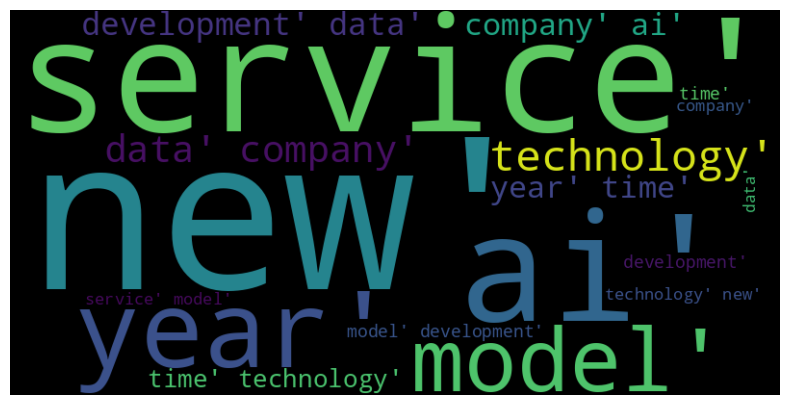

In [ ]:
import matplotlib.pyplot as plt

def generate_wordcloud(text):
    from wordcloud import WordCloud
    wordcloud = WordCloud(width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate word cloud for keywords
generate_wordcloud(' '.join(df['keywords'].explode()))

# Create simple report
def generate_report(df):
    report = f"Report Summary: {len(df)} AI-related articles analyzed.\n\n"
    for index, row in df.iterrows():
        # Changed 'title' to 'Title' to match the column name in the DataFrame
        report += f"Title: {row['Title']}\nSummary: {row['summary']}\nKeywords: {', '.join(row['keywords'])}\n\n"
    return report

# Save report to a text file
with open('ai_report.txt', 'w') as f:
    f.write(generate_report(df))

In [ ]:
!cat ai_report.txt


Report Summary: 139 AI-related articles analyzed.

Title: Samsung SDS is appointed as the new representative of Samsung Electronics, Lee Jun -hee
Summary: Samsung SDS announced on the 28th that Samsung Electronics Lee Jun -hee has appointed the vice president of Samsung Electronics as the new CEO. He is an IT and telecommunications technology expert who has earned a master's and doctorate degree in MIT.
Keywords: [, ', a, i, ', ,,  , ', t, i, m, e, ', ,,  , ', t, e, c, h, n, o, l, o, g, y, ', ,,  , ', n, e, w, ', ,,  , ', c, o, m, p, a, n, y, ', ,,  , ', y, e, a, r, ', ,,  , ', m, o, d, e, l, ', ,,  , ', s, e, r, v, i, c, e, ', ,,  , ', d, a, t, a, ', ,,  , ', d, e, v, e, l, o, p, m, e, n, t, ', ]

Title: Deep Nide launched next year…"Actual customs clearance test is imminent"
Summary: AI convergence customs clearance video management solution' project aims to complete the development next year. The number of overseas fastballs from e -commerce imported into Korea is increasing year by

In [ ]:
with open('ai_report.txt', 'r') as f:
    print(f.read())


Report Summary: 139 AI-related articles analyzed.

Title: Samsung SDS is appointed as the new representative of Samsung Electronics, Lee Jun -hee
Summary: Samsung SDS announced on the 28th that Samsung Electronics Lee Jun -hee has appointed the vice president of Samsung Electronics as the new CEO. He is an IT and telecommunications technology expert who has earned a master's and doctorate degree in MIT.
Keywords: [, ', a, i, ', ,,  , ', t, i, m, e, ', ,,  , ', t, e, c, h, n, o, l, o, g, y, ', ,,  , ', n, e, w, ', ,,  , ', c, o, m, p, a, n, y, ', ,,  , ', y, e, a, r, ', ,,  , ', m, o, d, e, l, ', ,,  , ', s, e, r, v, i, c, e, ', ,,  , ', d, a, t, a, ', ,,  , ', d, e, v, e, l, o, p, m, e, n, t, ', ]

Title: Deep Nide launched next year…"Actual customs clearance test is imminent"
Summary: AI convergence customs clearance video management solution' project aims to complete the development next year. The number of overseas fastballs from e -commerce imported into Korea is increasing year by

In [ ]:
# Create simple report
def generate_report(df):
    report = f"Report Summary: {len(df)} AI-related articles analyzed.\n\n"
    for index, row in df.iterrows():
        title = row['Title'] if pd.notnull(row['Title']) else "Unknown Title"
        summary = row['summary'] if pd.notnull(row['summary']) else "No summary available"
        classified_label = row['classified_label'] if pd.notnull(row['classified_label']) else "Uncategorized"
        link = row['link'] if pd.notnull(row['link']) else "No link available"

        report += (
            f"Title: {title}\n"
            f"Summary: {summary}\n"
            f"Classified Label: {classified_label}\n"
            f"Link: {link}\n\n"
        )
    return report

# Save report to a text file
with open('ai_report.txt', 'w', encoding='utf-8') as f:
    f.write(generate_report(df))


**Step 8: Automated Reports (Scheduled Execution)**

In [ ]:
from apscheduler.schedulers.blocking import BlockingScheduler

def scheduled_job():
    # Scrape new data, process, and generate report
    # (Integrate the above steps here)
    print("Generating new report...")
    # Save or send report

scheduler = BlockingScheduler()
scheduler.add_job(scheduled_job, 'interval', weeks=1)
scheduler.start()
